In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,dsfont}')

In [2]:
# Function for finding start and end points of the activity cycles
# Input: Rho , precision
# Output: startpoints &  endpoints

def StartAndEndPoints(Rho, precision):
    t=np.arange(0,len(Rho))
    tmax=max(t)
    threshold=min(Rho)
    flag=False
    i=0
    startlocs=[]
    endlocs=[]
    while i<(tmax-10):
        if ( Rho[i]-threshold <= precision ):
            i=i+1
            continue
        first=i
        if (Rho[i-1] < Rho[i]):
            first=first-1
            if i==0:
                first=0
        startlocs.append(first)
        flag=True
        while(flag and i<tmax-1):
            i=i+1
            if ( Rho[i]-threshold <= precision ):
                flag=False
        endlocs.append(i)
        i=i+1;
        
    return(startlocs,endlocs)

In [3]:
# Function for calculating burst width of a timeseri
# Input: Rho , precision
# Output: An array including the width of the burst at each time --> y

def BurstWidthActivity(Rho,precision):
    tmax=len(Rho)
    y=np.zeros(len(Rho))
    startlocs , endlocs = StartAndEndPoints(Rho,precision)
    startlocs.append(tmax)
    endlocs.append(tmax)
    if startlocs==[]:
        startlocs.append(0)
    if endlocs==[]:
        endlocs.append(0)
    imax=len(endlocs)-1
    i=0
    smean=9 # mean value of a silence interval (low-activity duration)
    a=startlocs[0]
    while (i<imax):
        if startlocs[i+1]-endlocs[i] < smean:
            i=i+1
            continue
        else:
            b=endlocs[i]
            c=b-a
            for j in np.arange(a,b):
                y[j] = c
            a=startlocs[i+1]
            i=i+1
    if (a<10):
        if all(v < 0.01 for v in Rho):
            y=np.zeros(len(Rho))
        else:    
            y=np.ones(len(y))
            y[0], y[len(y)-1] = 0, 0
    else:
        for i in np.arange(len(y)):
            if (y[i]!=0):
                y[i]=1
    return(np.array(y))

Standard metrics (not normalized):
True Positives (TP)      : 19
False Positives (FP)     : 30
False Negatives (FN)     : 4
True Negatives (TN)      : 331

Continued Positives (CP) : 242
Number of Memory Events  : 14
Average Memory Length    : 17.29
Longest Memory Event     : 36

Per-module total spurious memory:
  Module 1: 36 steps
  Module 2: 14 steps
  Module 3: 28 steps
  Module 4: 33 steps
  Module 5: 57 steps
  Module 6: 23 steps
  Module 7: 0 steps
  Module 8: 51 steps

All memory event lengths: [28, 36, 33, 6, 28, 10, 9, 14, 3, 13, 20, 11, 8, 23]



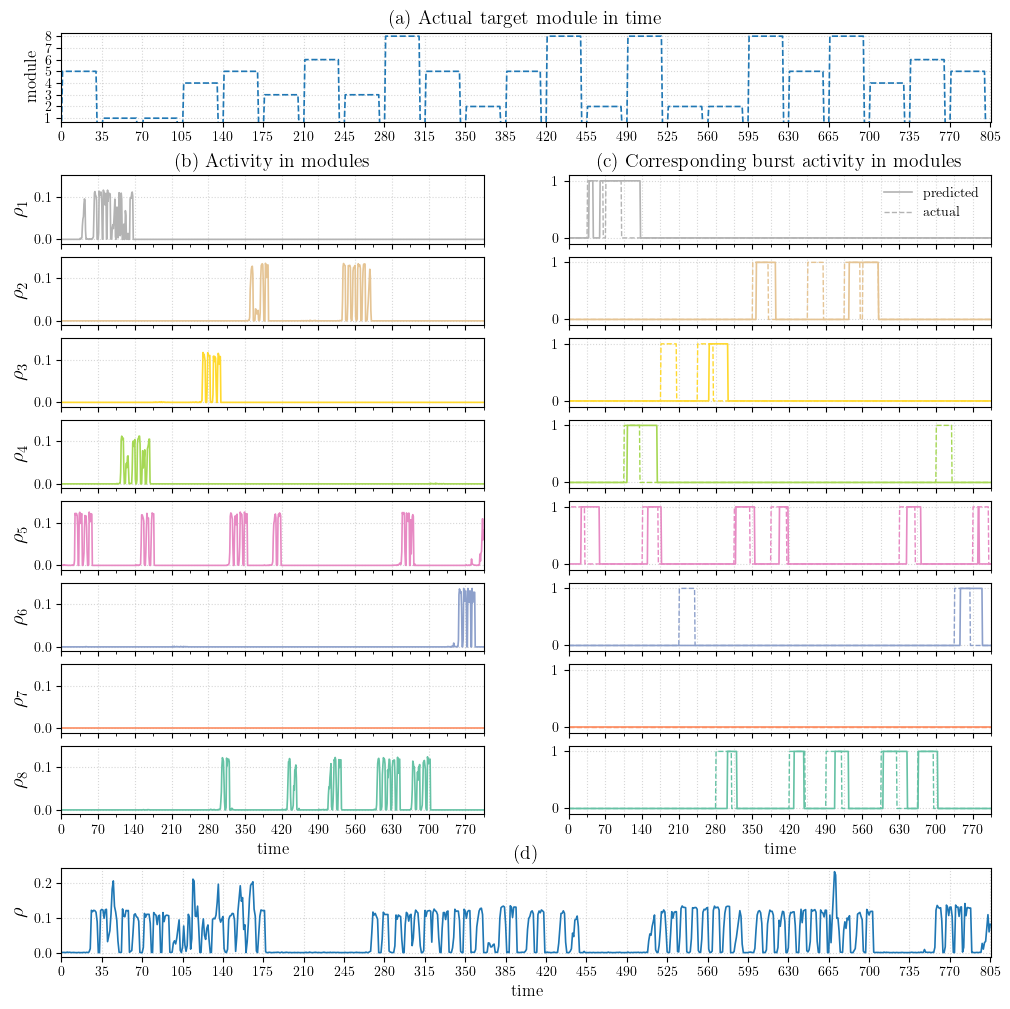

In [4]:
# Plot the total activity in time >>> rho(t)
import matplotlib.ticker as ticker
# =============================================================================
# LOAD DATA
# =============================================================================
data_name_1 = 'ActiveDens.txt'  # Predicted activity
d = np.loadtxt(data_name_1)

# Total activity: ρ1 to ρ8 → columns 1 to 8
Rho = np.sum(d[:, 1:9], axis=1)

# Target modules in time
data_name_2 = 'TargetModulesInTime.txt'  # Actual activity
tg = np.loadtxt(data_name_2).astype(int)

# =============================================================================
# PARAMETERS
# =============================================================================
# Set based on parameters in the C++ code
F = 0.4
tau_g = 30
tau_pause = 5
eta = 0.001

t = d[:, 0]
t_max = len(t)
left, right = 0, t_max

fs = 14
gg = tau_pause + tau_g
x_ticks = np.arange(0, t_max, gg)
ll = 1.2

#coff=3.7
precision=0.005

n = 8
colors = plt.cm.Set2(np.linspace(0, 1, n))
m_names = [r'$\rho_1$', r'$\rho_2$', r'$\rho_3$', r'$\rho_4$',
           r'$\rho_5$', r'$\rho_6$', r'$\rho_7$', r'$\rho_8$']

# Making Predicted and Actual matices based on input files
predicted_matrix=np.zeros((8,t_max))
for i in np.arange(1,9):
    predicted_matrix[i-1,:]=BurstWidthActivity(d[:, i],precision)

actual_matrix=np.zeros((8,t_max))
for i in np.arange(t_max):
    if (tg[i]==1):
        row = 0
        actual_matrix[row,i] = 1
    elif (tg[i]!=0):
        row = tg[i] - 1
        actual_matrix[row,i] = 1

# =============================================================================
# FIGURE
# =============================================================================
fig = plt.figure(figsize=(12, 12), facecolor='white')
gs = GridSpec(12, 2, height_ratios=[1.3, .4, 1, 1, 1, 1, 1, 1, 1, 1, .4, 1.3])

# --- Actual target module in time ---
ax_actual = fig.add_subplot(gs[0,:])
plt.plot(t, tg, '--', lw=ll, color='C0')
plt.xlim(left, right)
plt.ylabel('module', fontsize=fs-2)
plt.xticks(x_ticks)
plt.grid(linestyle=':', alpha=0.5)
ax_actual.set_yticks([1,2,3,4,5,6,7,8])
#ax_actual.set_xticklabels([])
plt.title('(a) Actual target module in time', fontsize=fs)
plt.ylim([0.7,8.3])

# --- Total ρ ---
ax_rho = fig.add_subplot(gs[11,:])
plt.plot(t, Rho, lw=ll, color='C0')
plt.xlim(left, right)
plt.ylabel(r'$\rho$', fontsize=fs+1)
plt.xticks(x_ticks)
plt.grid(linestyle=':', alpha=0.5)
plt.xlabel('time', fontsize=fs-2)
plt.title('(d)', fontsize=fs)

# --- ρ_m for modules 1 to 8 ---
for i in range(1, 9):
    R = d[:, i]
    ax1 = fig.add_subplot(gs[i+1,0])
    plt.plot(t, R, color=colors[8-i], lw=ll, label=m_names[i-1])
    plt.xlim(left, right)
    plt.ylabel(m_names[i-1], fontsize=fs+1)
    plt.xticks(x_ticks)
    plt.ylim([-0.01,0.15])
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(70))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(35))
    plt.grid(linestyle=':', alpha=0.5)
    if i!=8:
        ax1.set_xticklabels([])
    else:
        plt.xlabel('time', fontsize=fs-2)
    if i==1:
        plt.title('(b) Activity in modules', fontsize=fs)
    
    ax2 = fig.add_subplot(gs[i+1,1])
    plt.plot(predicted_matrix[i-1,:], color=colors[8-i], label='predicted', lw=ll)
    plt.plot(actual_matrix[i-1,:], '--', color=colors[8-i], label='actual', lw=ll-0.2)
    plt.xlim(left, right)
    #plt.ylabel(r'$\to$', fontsize=fs-2,rotation='horizontal')
    plt.xticks(x_ticks)
    plt.ylim([-0.1,1.1])
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(70))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(35))
    plt.grid(which='both', linestyle=':', alpha=0.5)
    if i!=8:
        ax2.set_xticklabels([])
    else:
        plt.xlabel('time', fontsize=fs-2)
    if i==1:
        plt.title('(c) Corresponding burst activity in modules', fontsize=fs)
        plt.legend(frameon=False)

# =============================================================================
#  CALCULATIONS
# =============================================================================
# Initialize counters
TP = FP = FN = TN = DP = CP = 0
CP_per_module = np.zeros(8, dtype=int)

# Standard metrics
for row in range(8):
    col = 1
    while col<=t_max:
        sum_actual_g = np.sum(actual_matrix[row, col:col+tau_g])
        sum_predicted_g = np.sum(predicted_matrix[row, col:col+tau_g])
        if (sum_actual_g != 0 and sum_predicted_g != 0 ):
            TP += 1
        elif (sum_actual_g != 0 and sum_predicted_g == 0 ):
            FN += 1
        elif (sum_actual_g == 0 and sum_predicted_g != 0 ):
            FP += 1
        elif (sum_actual_g == 0 and sum_predicted_g == 0 ):
            TN += 1
        
        col = col + tau_g

        sum_actual_p = np.sum(actual_matrix[row, col:col+tau_pause])
        sum_predicted_p = np.sum(predicted_matrix[row, col:col+tau_pause])
        if (sum_actual_p != 0 and sum_predicted_p != 0 ):
            TP += 1
        elif (sum_actual_p != 0 and sum_predicted_p == 0 ):
            FN += 1
        elif (sum_actual_p == 0 and sum_predicted_p != 0 ):
            FP += 1
        elif (sum_actual_p == 0 and sum_predicted_p == 0 ):
            TN += 1
        
        col = col + tau_pause

# For tracking individual memory events
memory_events = []                    # List of (module, start_col, length)
memory_lengths = []                   # Just the lengths: [20, 5, 12, ...]
memory_lengths_per_module = {i: [] for i in range(8)}

# Track: for each module, when did the true activity end (and prediction is still on?)
# We use a list of active "persistence start times"
persistence_start = [-1] * 8   # -1 means no ongoing persistence for that module

was_active = np.zeros(8, dtype=bool)

for col in range(t_max):
    actual_col    = actual_matrix[:, col]
    predicted_col = predicted_matrix[:, col]

    for row in range(8):
        a = actual_col[row]
        p = predicted_col[row]

        # ─────────────── CP: Track persistence length ───────────────
        # Case 1: True activity just ended → start counting persistence
        if was_active[row] and a == 0 and p == 1:
            if persistence_start[row] == -1:  # first step of persistence
                persistence_start[row] = col

        # Case 2: Persistence is ongoing (actual=0, pred=1, and we already started counting)
        elif a == 0 and p == 1 and persistence_start[row] != -1:
            pass  # just wait

        # Case 3: Persistence ends (prediction finally turns off)
        elif a == 0 and p == 0 and persistence_start[row] != -1:
            length = col - persistence_start[row]
            CP += length
            CP_per_module[row] += length
            memory_events.append((row, persistence_start[row], length))
            memory_lengths.append(length)
            memory_lengths_per_module[row].append(length)
            persistence_start[row] = -1  # reset

        # Case 4: True activity is back → cancel any ongoing count (optional)
        elif a == 1:
            if persistence_start[row] != -1:
                # Optional: cancel partial count if true activity resumes
                persistence_start[row] = -1

    # Update previous state
    was_active = (actual_col == 1)

# ─── Don't forget: if persistence continues until the very end → count it!
for row in range(8):
    if persistence_start[row] != -1:
        length = t_max - persistence_start[row]
        CP += length
        CP_per_module[row] += length
        memory_events.append((row, persistence_start[row], length))
        memory_lengths.append(length)
        memory_lengths_per_module[row].append(length)

# ────────────────── Final Results ──────────────────
print('Standard metrics (not normalized):')
print(f"True Positives (TP)      : {np.round(TP,2)}")
print(f"False Positives (FP)     : {np.round(FP,2)}")
print(f"False Negatives (FN)     : {np.round(FN,2)}")
print(f"True Negatives (TN)      : {np.round(TN,2)}")
print()
print(f"Continued Positives (CP) : {CP}")
print(f"Number of Memory Events  : {len(memory_events)}")
print(f"Average Memory Length    : {CP / len(memory_events) if memory_events else 0:.2f}")
print(f"Longest Memory Event     : {max(memory_lengths) if memory_lengths else 0}")
print("\nPer-module total spurious memory:")
for row in range(8):
    print(f"  Module {row+1}: {CP_per_module[row]} steps")
print("\nAll memory event lengths:", memory_lengths)
print()
        
#plt.savefig('burst_alg.pdf', dpi=300, bbox_inches='tight')